In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

# Experiment 1

In [17]:
data_path = "data/"
e1_file_names = ["experiment 1 run 1.txt", "experiment 1 run 2.txt", "experiment 1 run 3.txt"]
e1_data = []

for file_name in e1_file_names:
    file_path = data_path + file_name
    db_temp = pd.read_csv(file_path, sep="\t", decimal=",", header=None)

    e1_column_names = db_temp.iloc[0]
    e1_units = db_temp.iloc[1]

    db_temp = db_temp[2:]
    db_temp.columns = e1_column_names

    db_temp = db_temp.apply(lambda col: col.str.replace(",", ".").astype(float) if col.dtype == "object" else col)
    e1_data.append(db_temp)

# Test
print(e1_data[0].head())
print(len(e1_data[0]["Tijd"]))
print(len(e1_data[0]["Ch1"]))

0   Tijd     Ch1     Ch2
2  0.000  1019.0  1007.0
3  0.455  1019.0  1007.0
4  1.089  1019.0  1007.0
5  2.088  1019.0  1007.0
6  3.088  1019.0  1007.0
1079
1079


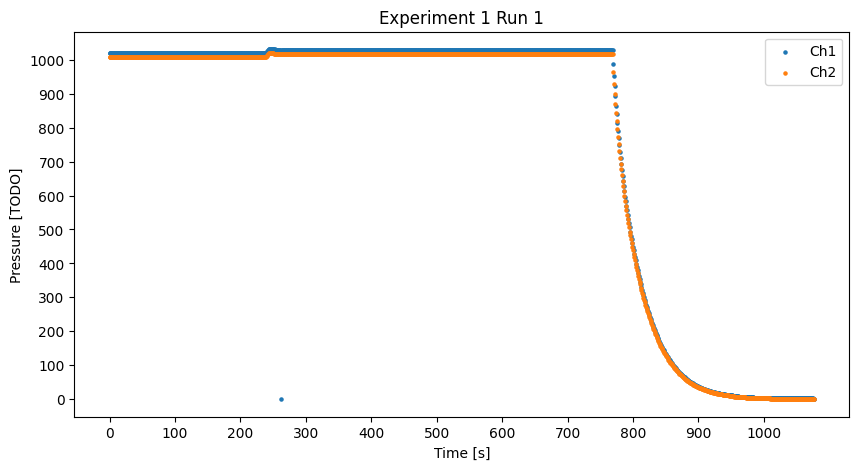

In [ ]:
# Plot test 1 to extract relevant part
plt.figure(figsize=(10, 5))
plt.scatter(e1_data[0]['Tijd'], e1_data[0]['Ch1'], label='Ch1', s=5)
plt.scatter(e1_data[0]['Tijd'], e1_data[0]['Ch2'], label='Ch2', s=5)

plt.xlabel('Time [s]')
plt.ylabel('Pressure [TODO]')
plt.title('Experiment 1 Run 1')

plt.xticks(ticks=np.arange(0, len(e1_data[0]['Tijd']), step=100))
plt.yticks(ticks=np.arange(0, len(e1_data[0]['Ch1']), step=100))

plt.legend()
plt.show()

# Note to self: Drop seems to be around 750-780 s

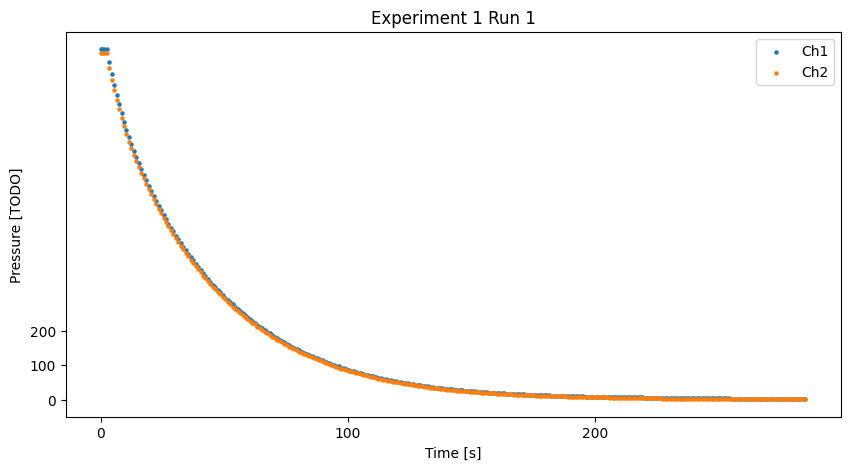

In [ ]:
# Plot test 1 to extract relevant part
plt.figure(figsize=(10, 5))
plt.scatter(e1_data[1]['Tijd'], e1_data[1]['Ch1'], label='Ch1', s=5)
plt.scatter(e1_data[1]['Tijd'], e1_data[1]['Ch2'], label='Ch2', s=5)

plt.xlabel('Time [s]')
plt.ylabel('Pressure [TODO]')
plt.title('Experiment 1 Run 1')

plt.xticks(ticks=np.arange(0, len(e1_data[1]['Tijd']), step=100))
plt.yticks(ticks=np.arange(0, len(e1_data[1]['Ch1']), step=100))

plt.legend()
plt.show()

# Note to self: Just cut-off the first few seconds, drop is almost immediate

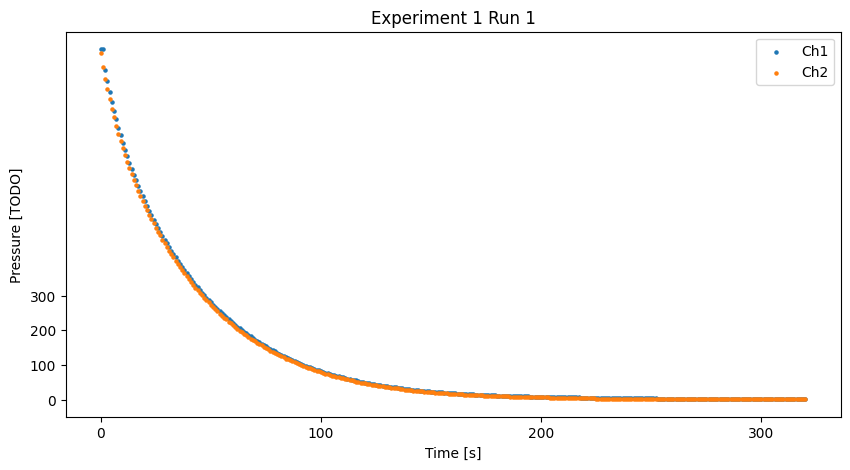

In [20]:
# Plot test 1 to extract relevant part
plt.figure(figsize=(10, 5))
plt.scatter(e1_data[2]['Tijd'], e1_data[2]['Ch1'], label='Ch1', s=5)
plt.scatter(e1_data[2]['Tijd'], e1_data[2]['Ch2'], label='Ch2', s=5)

plt.xlabel('Time [s]')
plt.ylabel('Pressure [TODO]')
plt.title('Experiment 1 Run 1')

plt.xticks(ticks=np.arange(0, len(e1_data[2]['Tijd']), step=100))
plt.yticks(ticks=np.arange(0, len(e1_data[2]['Ch1']), step=100))

plt.legend()
plt.show()

# Note to self: Just cut-off the first few seconds, drop is almost immediate

# Experiment 2